# Benjamin Pedigo 
bpedigo@uw.edu  
August-September, 2017  
Computational Neuroanatomy Internship

The following are a series of plots I made from the 170605_nt... (see below) graph from Princeton.

**Imports and definitions**


In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import time
from matplotlib.legend_handler import HandlerLine2D
from scipy.stats import binned_statistic
import os
import sys
import matplotlib

###############################################################################
# Make sure these are set to the proper locations for your directory setup
GRAPH_NAME = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\170605_nt_v11_mst_trimmed_sem_final_edges.csv'
CELL_NAME = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\20170818_cell_list_with_soma.csv'
STL_FOLDER = 'C:\\Users\\benjaminp\\Desktop\\NeuronReconstructions\\true_all_stl\\'

FIGURE_WIDTH = 16
FIGURE_HEIGHT = 9
VOX_W = 3.6
VOX_H = 3.6
VOX_D = 40
VOX_VOL = VOX_W * VOX_H * VOX_D
DPI = 500

###############################################################################
# some functions may not be used yet
def get_subgraphs(cell_id, inout):
    '''Output: 
    all, smooth, spiny
    '''
    
    if inout == 'in':
        all_graph = postsyn_cells_graph[postsyn_cells_graph.segs_2 == cell_id]
        smooth_graph = all_graph[all_graph['segs_1'].isin(smooth_cells)]
        spiny_graph = all_graph[all_graph['segs_1'].isin(spiny_cells)]
    elif inout == 'out':
        all_graph = presyn_cells_graph[presyn_cells_graph.segs_1 == cell_id]
        smooth_graph = all_graph[all_graph['segs_2'].isin(smooth_cells)]
        spiny_graph = all_graph[all_graph['segs_2'].isin(spiny_cells)]
    
    return all_graph, smooth_graph, spiny_graph

def crappy_shifter(coord):
    '''
    Bad way of mapping graph coordinates to that used by the converted stl files
    Was mostly determined by looking at max/mins and trial and error, so likely 
    not quite exact.
    
    coord should be a 3 element iterable
    
    output is a list of x,y,z coordinate that should agree with stl frame
    
    '''
    
    shift = np.array([0.10245, 0.07687, 0])
    coord_shift = coord * 0.00001
    coord_shift = coord_shift - shift
    coord_shift[0] = coord_shift[0]*4
    coord_shift[1] = coord_shift[1]*4
    coord_shift[2] = coord_shift[2]*40
    return coord_shift

def crappy_matrix_shifter(mat):
    shift = np.array([0.10245, 0.07687, 0])
    shift_mat = np.tile(shift, (mat.shape[0],1))
    mat = mat * 0.00001
    mat = mat - shift_mat
    mat[:,0] = mat[:,0] * 4
    mat[:,1] = mat[:,1] * 4
    mat[:,2] = mat[:,2] * 40
    return mat
    
def process_df(graph_for_cell):
    '''
    input - dataframe
    
    output - list of xyz coordinates
    '''
    
    coords=[]
    for i in range(graph_for_cell.shape[0]):
        coord = graph_for_cell.iloc[i,:]
        coord = coord.loc['loc_x':'loc_z'].as_matrix()
        coord_shift = crappy_shifter(coord)
        coords.append(coord_shift)
    return coords

def get_subgraph2(cell_id, full_graph, inout):
    if inout == 'in':
        subgraph = full_graph[full_graph.segs_2 == cell_id]
        
    elif inout == 'out':
        subgraph = full_graph[full_graph.segs_1 == cell_id]

    return subgraph

def get_cell_type(cell_id):
    indx = np.where(cell_id_array == cell_id)[0][0]
    return cell_type_array[indx]

def calc_volume(corners):
    # broken!!!!
    # corners : [x1 y1 z1 x2 y2 z2]
    x_len = corners[3] - corners[0] + 1
    y_len = corners[4] - corners[1] + 1
    z_len = corners[5] - corners[2] + 1
    volume = x_len*y_len*z_len
    return volume

def calc_volumes_for_graph(graph):
    syn_volumes = np.zeros(graph.shape[0])
    
    for i in range(graph.shape[0]):
        bbox_corners = graph.iloc[i,:].loc['bboxes_1':'bboxes_6'].as_matrix()
        bbox_volume = calc_volume(bbox_corners)
        syn_volumes[i] = bbox_volume
    
    return syn_volumes


class Printer():
    """Print things to stdout on one line dynamically"""
    def __init__(self,data):
        sys.stdout.write("\r\x1b[K"+data.__str__())
        sys.stdout.flush()

def fix_manual_hist(vals):
    step_vals = np.insert(vals, 0, vals[0])
    step_vals = np.insert(step_vals, 0, 0)
    step_vals = np.append(step_vals, 0)
    
    return step_vals

def make_prop_hist(vals, bins, fix = False): 
    num_below = np.where(vals <= bins[-1])[0].shape[0]

    if num_below == 0:
        return np.zeros(len(bins)+2), 0
        
    weights = np.ones_like(vals)/float(num_below)

    binned_vals, bins = np.histogram(vals, bins,
                                normed = False, 
                                weights = weights)
    
   
    if fix:
        binned_vals = fix_manual_hist(binned_vals)
    
    
    
    return binned_vals, num_below

def make_hist_from_list(cell_ids,bins,  inout, fix = False):
    props_by_cell = []
    n_each_cell = np.empty(cell_ids.shape)
    
    for i, cell_id in enumerate(cell_ids):        
        cell_graph = get_subgraph2(cell_id, FULL_GRAPH,inout)
        
        cell_syn_volumes = cell_graph.sizes.values
        cell_syn_volumes = cell_syn_volumes * VOX_W * VOX_H * VOX_D
        #cell_syn_volumes = cell_syn_volumes / 10**(9)
        
        
        vals,n  = make_prop_hist(cell_syn_volumes, bins,)
        n_each_cell[i] = n
        if n != 0:
            props_by_cell.append(vals)
        
    bin_mat = np.array(props_by_cell)
    mean_by_bin = np.mean(bin_mat, axis = 0)
    
    if fix:
        mean_by_bin = fix_manual_hist(mean_by_bin)
    
    return mean_by_bin, n_each_cell

# Make some sub-dataframes for use later
full_graph = pd.read_csv(GRAPH_NAME)
FULL_GRAPH = full_graph

cell_list = pd.read_csv(CELL_NAME)
all_cells = cell_list.as_matrix(columns = ['cell_id'])
all_cells = all_cells.flatten()
cell_types = cell_list.as_matrix(columns = ['cell_type'])
cell_types = cell_types.flatten()

presyn_cells_graph = full_graph[full_graph['segs_1'].isin(all_cells)]
postsyn_cells_graph = full_graph[full_graph['segs_2'].isin(all_cells)]

smooth_cells_idx = np.where(cell_types == 'I')
smooth_cells = all_cells[smooth_cells_idx]

spiny_cells_idx = np.where(cell_types == 'E')
spiny_cells = all_cells[spiny_cells_idx]

classified_cells = np.concatenate((spiny_cells, smooth_cells))


font = {'weight' : 'normal',
        'size'   : '18'}

matplotlib.rc('font', **font)

**Slow way (that I should have vectorized) for calculating the bounding box area for each synapse**

In [3]:
all_syn_volumes = np.zeros(full_graph.shape[0])
print 'Working'
for i in range(full_graph.shape[0]):
    bbox_corners = full_graph.iloc[i,:].loc['bboxes_1':'bboxes_6'].as_matrix()
    bbox_volume = calc_volume(bbox_corners)
    all_syn_volumes[i] = bbox_volume
    if i % 10000 == 0:
        Printer('%' + str(100*i/float(full_graph.shape[0])))
print ''
print 'Done'

Working
%99.89874669484
Done


**Plotting histograms for synapse size, different cell types**

Sum of heights for each histogram:
0.999999999999
1.0
1.0
1.0


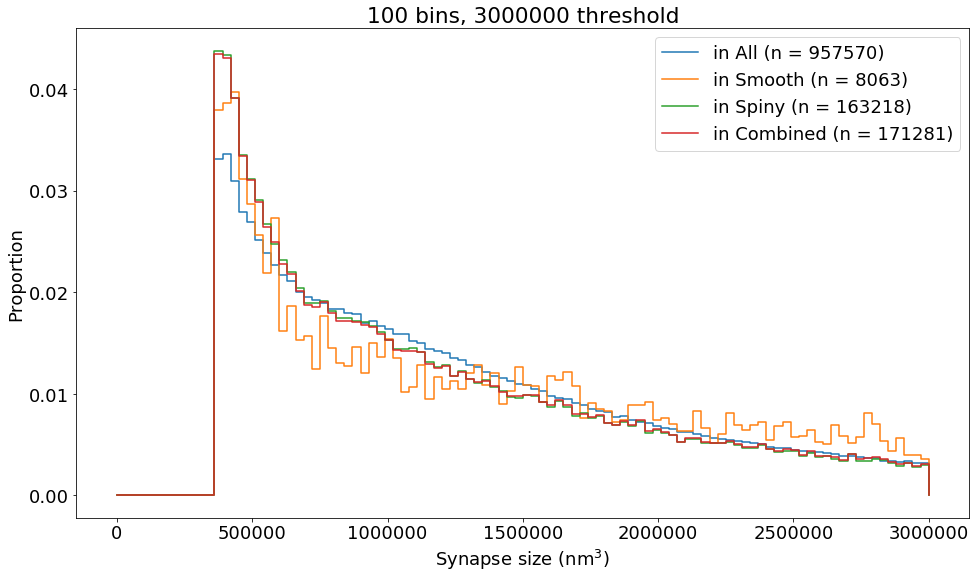

In [22]:
# toggle
inout = 'in'
save = True
num_bins = 100
threshold = 3000000
bins = np.linspace(0, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])
all_vol = FULL_GRAPH.sizes.values
all_vol = all_vol * VOX_W * VOX_H * VOX_D
# if you want to get to um^3
#all_vol = all_vol / 10**(9)

all_binned, n_all = make_prop_hist(all_vol, bins, fix = True)
smooth_binned, n_smooth = make_hist_from_list(smooth_cells, bins, inout, fix=True)
spiny_binned, n_spiny = make_hist_from_list(spiny_cells, bins, inout, fix=True)
combined_binned, n_combined = make_hist_from_list(classified_cells, bins, inout, fix=True)

all_label = inout + ' All (n = %i)' %(n_all)
smooth_label = inout + ' Smooth (n = %i)' %(n_smooth.sum())
spiny_label = inout + ' Spiny (n = %i)' %(n_spiny.sum())
combined_label = inout + ' Combined (n = %i)' %(n_combined.sum())

fig2 = plt.figure(1, figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
p1 = plt.plot(step_bins, all_binned, drawstyle = 'steps', label = all_label)
p2 = plt.plot(step_bins, smooth_binned, drawstyle = 'steps', label = smooth_label)
p3 = plt.plot(step_bins, spiny_binned, drawstyle = 'steps', label = spiny_label)
p4 = plt.plot(step_bins, combined_binned, drawstyle = 'steps', label = combined_label)

# Double check that proportion is working correctly
print('Sum of heights for each histogram:')
print(sum(all_binned[2:-1]))
print(sum(smooth_binned[2:-1]))
print(sum(spiny_binned[2:-1]))
print(sum(combined_binned[2:-1]))

title = '%i bins, %i threshold' %(num_bins, threshold)
plt.title(title)
plt.legend()
plt.xlabel('Synapse size (nm$^3$)')
plt.ylabel('Proportion')

if save:
    save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
    save_loc = save_dir + '\\' + '4lines' + '_' + inout + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
    plt.savefig(save_loc, dpi=500)


**I manually estimated the center of the soma for the first 40 cells in all_cells. I made a few plots looking at distribution of synapses in terms of euclidian distance from the center of the soma. **

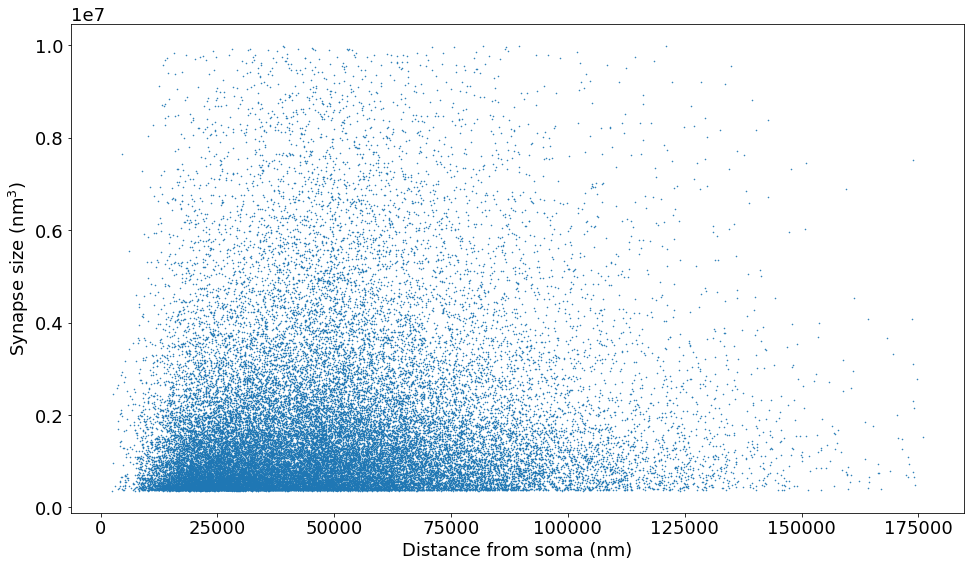

In [76]:
save = True
threshold = 1e7

for_cell_dists = []
for_cell_volumes = []

for i in range(0,40):
    cell_id = all_cells[i]
    cell_info = cell_list.loc[cell_list['cell_id'] == cell_id]
    soma_loc = cell_info.loc[:,'soma_x':'soma_z'].as_matrix()[0]
    #print('soma')
    #print(soma_loc)
    soma_loc = soma_loc * 10**5
    #print(soma_loc)
    soma_loc = soma_loc + [40960, 30720, 0]
    #print(soma_loc)
    
    cell_graph = get_subgraph2(cell_id, FULL_GRAPH, 'in')
    cell_locs = cell_graph.loc[:, 'locs_1':'locs_3'].as_matrix()
    #print('syn')
    shift_stacked = np.tile([VOX_W, VOX_H, VOX_D],(cell_locs.shape[0],1))
   # print(cell_locs[0:1])
    cell_locs = np.multiply(cell_locs, shift_stacked)
    #print(cell_locs[0:1])
    

    soma_loc_stacked = np.tile(soma_loc, (cell_locs.shape[0],1))
    diff_mat = soma_loc_stacked - cell_locs
    squared_diff_mat = np.multiply(diff_mat, diff_mat)
    syn_dists = np.sum(squared_diff_mat, axis = 1)
    syn_dists = syn_dists**(0.5)
    syn_volumes = cell_graph.sizes.values
    syn_volumes = syn_volumes * VOX_VOL
    
    for_cell_dists.append(syn_dists)
    for_cell_volumes.append(syn_volumes)

all_dists = np.concatenate(for_cell_dists)
all_volumes = np.concatenate(for_cell_volumes)

volume_idx = np.where(all_volumes <= threshold)
all_dists_filt = all_dists[volume_idx]
all_volumes_filt = all_volumes[volume_idx]

# not necessary?
dist_idx = np.where(all_dists_filt > .13) #.13
all_dists_filt2 = all_dists_filt[dist_idx]
all_volumes_filt2 = all_volumes_filt[dist_idx]

fig = plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.scatter(all_dists_filt, all_volumes_filt,s=0.3)
plt.xlabel('Distance from soma (nm)')
plt.ylabel('Synapse size (nm$^3$)')

if save:
    save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
    save_loc = save_dir + '\\' + 'scatter' + '_' + 'first40' + '_' + str(threshold) + '.png' 
    plt.savefig(save_loc, dpi=DPI)


**Distribution of distances from soma**

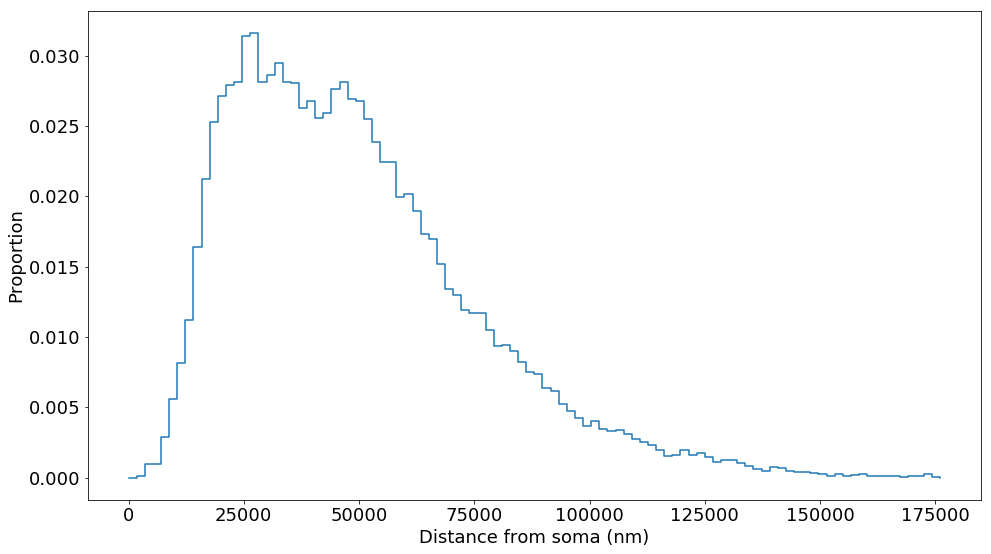

In [75]:
save = True
num_bins = 100

bins = np.linspace(0, max(all_dists_filt), num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])

fig2 = plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))

vals, n = make_prop_hist(all_dists_filt, bins, fix=True)
plt.plot(step_bins, vals, drawstyle = 'steps')
plt.xlabel('Distance from soma (nm)')
plt.ylabel('Proportion')

if save:
    save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
    save_loc = save_dir + '\\' + 'distance' + '_' + 'all' + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
    plt.savefig(save_loc)

**Relationship between bounding box and synapse size**

Correlation between synapse size and bounding box size:
0.696598682005


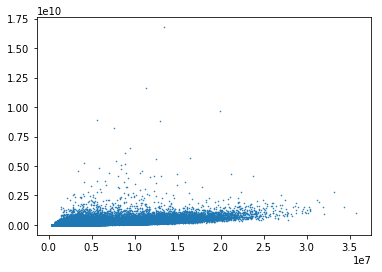

In [24]:
plt.scatter(all_vol, all_box_vol, s=0.3)
print('Correlation between synapse size and bounding box size:')
print(np.corrcoef(all_vol, all_box_vol)[0,1])

**Relationship between bounding box and synapse size when using a threshold, looking at same axes scales**

0.838278226086


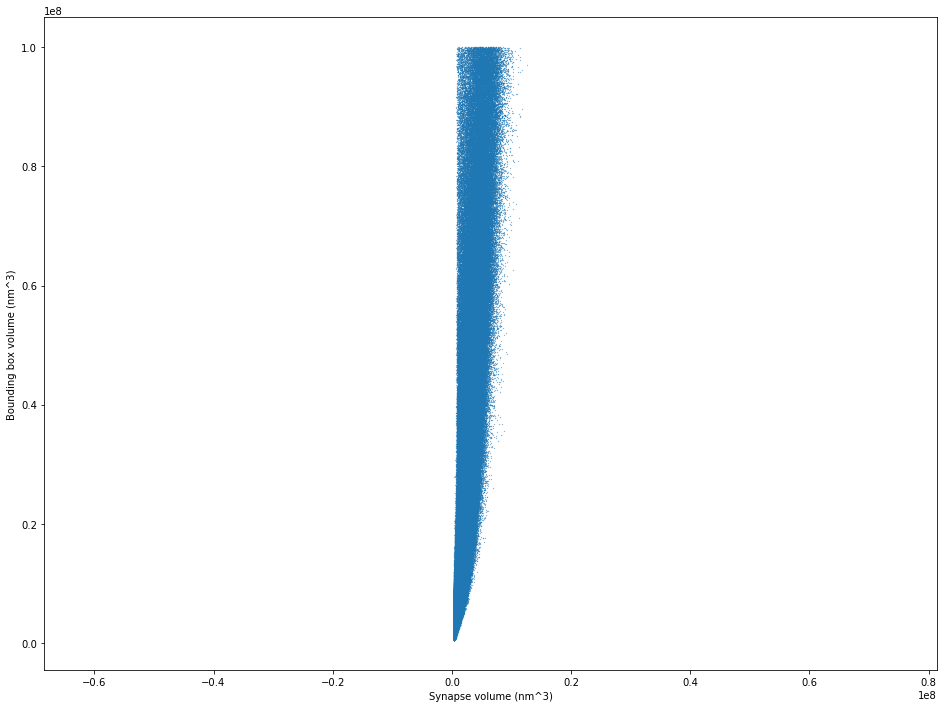

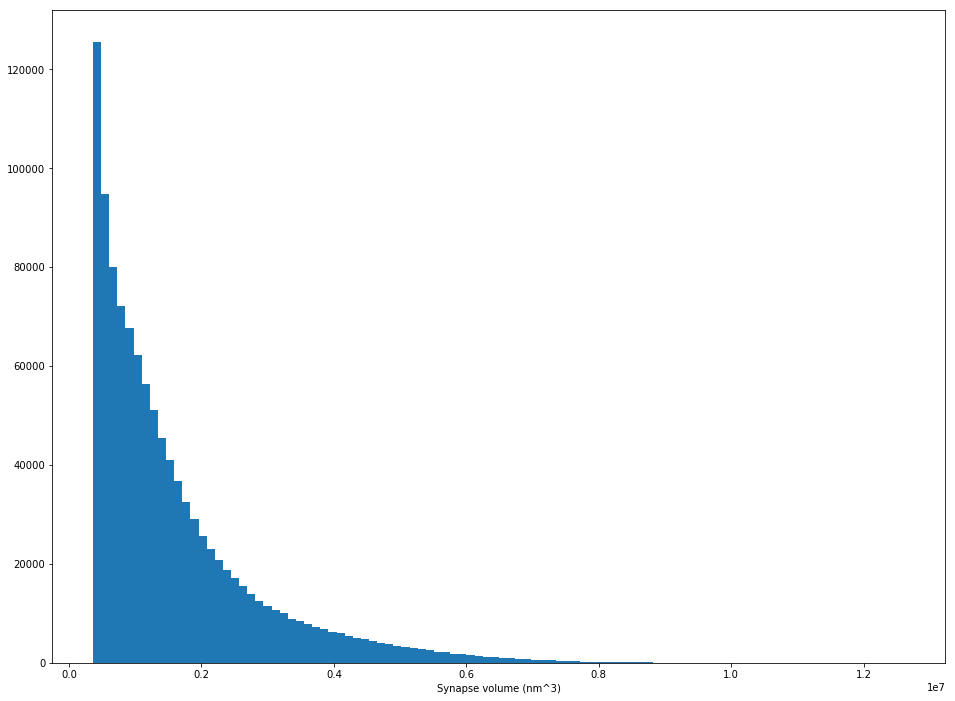

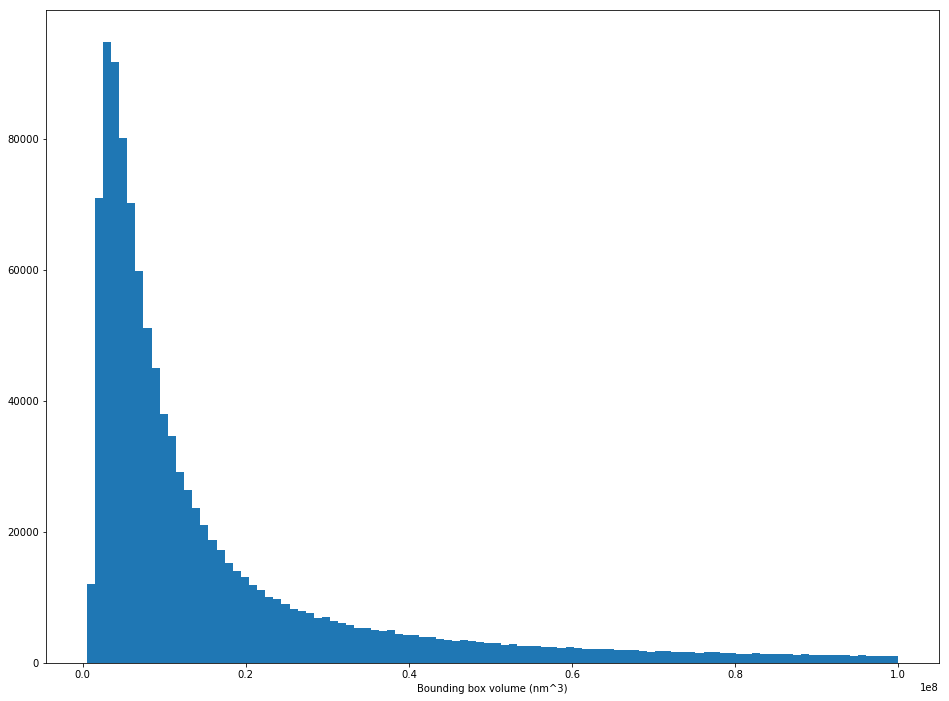

In [25]:
syn_thresh = 1e9
box_thresh = 1e8
num_bins = 100

all_vol_filt_idx = np.where(all_vol <= syn_thresh)[0]
all_vol_filt1 = all_vol[all_vol_filt_idx]
all_box_vol_filt1 = all_box_vol[all_vol_filt_idx]

all_box_filt_idx = np.where(all_box_vol_filt1 <= box_thresh)[0]
all_box_vol_filt2 = all_box_vol_filt1[all_box_filt_idx]
all_vol_filt2 = all_vol_filt1[all_box_filt_idx]

plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.scatter(all_vol_filt2, all_box_vol_filt2, s = 0.05)
plt.axis('equal')
plt.xlabel('Synapse volume (nm^3)')
plt.ylabel('Bounding box volume (nm^3)')

save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
save_loc = save_dir + '\\syn_vs_box_%i_%i.png' %(syn_thresh, box_thresh) 
plt.savefig(save_loc)


plt.figure(2, figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.hist(all_vol_filt2, num_bins)
plt.xlabel('Synapse volume (nm^3)')

plt.figure(3, figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.hist(all_box_vol_filt2, num_bins)
plt.xlabel('Bounding box volume (nm^3)')

print(np.corrcoef(all_vol_filt2, all_box_vol_filt2)[0,1])

**Looking at dimensions of bounding boxes for Forrest**

In [24]:
first_points = FULL_GRAPH.loc[:,'bboxes_1':'bboxes_3'].as_matrix()
second_points = FULL_GRAPH.loc[:,'bboxes_4':'bboxes_6'].as_matrix()
shift = [3.6, 3.6, 40]
first_pnts_shift = np.multiply(first_points, shift)
second_pnts_shift = np.multiply(second_points, shift)
diff = second_pnts_shift - first_pnts_shift
mean_diff = np.mean(diff, axis = 0)
std_diff = np.std(diff, axis = 0)
median_diff = np.median(diff, axis = 0)

print('Mean (x,y,z) bounding box dimensions:')
print(mean_diff)
print('Median (x,y,z) bounding box dimensions:')
print(median_diff)
print('Standard deviation (x,y,z) of bounding box dimensions:')
print(std_diff)

Mean (x,y,z) bounding box dimensions:
[ 255.48067416  228.32076438  271.01734175]
Median (x,y,z) bounding box dimensions:
[ 212.4  190.8  240. ]
Standard deviation (x,y,z) of bounding box dimensions:
[ 159.77081539  139.46587295  171.316484  ]


**Plot the distribution of x, y, and z dimensions.**

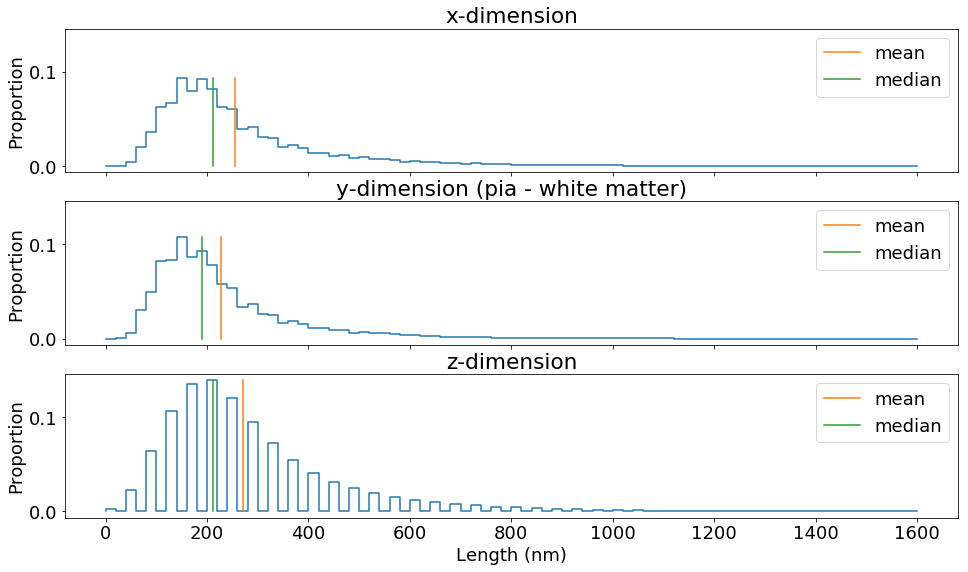

In [28]:
font = {'weight' : 'normal',
        'size'   : '18'}

matplotlib.rc('font', **font)


diff_x = diff[:, 0]
diff_y = diff[:, 1]
diff_z = diff[:, 2]

num_bins = 80
threshold = 1600
bins = np.linspace(0, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])

binned_x_f, _ = make_prop_hist(diff_x, bins, fix=True)
binned_y_f, _ = make_prop_hist(diff_y, bins, fix=True)
binned_z_f, _ = make_prop_hist(diff_z, bins, fix=True)

plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))

ax1 = plt.subplot(3,1,1)
plt.plot(step_bins, binned_x_f, drawstyle='steps', label = '')
plt.plot([mean_diff[0], mean_diff[0]], [0, max(binned_x_f)], label = 'mean')
plt.plot([median_diff[0], median_diff[0]], [0, max(binned_x_f)], label = 'median')
plt.setp(ax1, xticklabels=[])
plt.ylabel('Proportion')
plt.title('x-dimension')
plt.legend()

ax2 = plt.subplot(3,1,2, sharey=ax1)
plt.plot(step_bins, binned_y_f, drawstyle='steps')
plt.plot([mean_diff[1], mean_diff[1]], [0, max(binned_y_f)], label = 'mean')
plt.plot([median_diff[1], median_diff[1]], [0, max(binned_y_f)], label = 'median')
plt.setp(ax2, xticklabels=[])
plt.ylabel('Proportion')
plt.title('y-dimension (pia - white matter)')
plt.legend()


plt.subplot(3,1,3, sharey=ax1)
plt.plot(step_bins, binned_z_f, drawstyle='steps')
plt.plot([mean_diff[2], mean_diff[2]], [0, max(binned_z_f)], label = 'mean')
plt.plot([median_diff[0], median_diff[0]], [0, max(binned_z_f)], label = 'median')
plt.ylabel('Proportion')
plt.xlabel('Length (nm)')
plt.title('z-dimension')
plt.legend()

save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
save_loc = save_dir + '\\' + 'xyz_size' + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
plt.savefig(save_loc, dpi=DPI)


**Tried to look at the distribution of synapse volume as a function of the y-dimension. Looks like it is fairly homogenous, although if there is no threshold (threshold = inf), the standard deviation is so big that +- 1 stdev more than covers [0 mean]. This could be extended to be used once more than one cortical layer is available. **

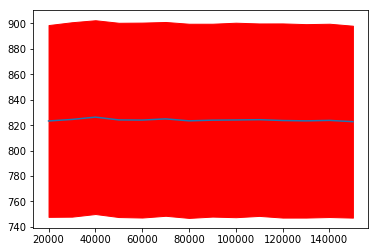

In [33]:
y_locs = FULL_GRAPH.locs_2.as_matrix()
y_locs_shft = y_locs * VOX_H

all_vol = FULL_GRAPH.sizes.as_matrix()
all_vol_shft = all_vol * VOX_VOL

thresh = 500000
thresh_idx = np.where(all_vol_shft < thresh)[0]
all_vol_shft = all_vol[thresh_idx]
y_locs_shft = y_locs_shft[thresh_idx]


np.corrcoef(y_locs_shft, all_vol_shft)[0,1]
step = 10000
start = min(y_locs_shft) - min(y_locs_shft)%step
stop = max(y_locs_shft) - max(y_locs_shft)%step + step
y_steps = np.arange(start, stop + step, step)
mean_by_layer = []
num_by_layer = []
std_by_layer = []
for i in range(len(y_steps) - 1):
    ys_above = np.where(y_locs_shft > y_steps[i])[0]
    ys_below = np.where(y_locs_shft <= y_steps[i + 1])[0]
    ys_in = np.intersect1d(ys_above, ys_below)
    num_in = len(ys_in)
    vol_in = all_vol_shft[ys_in]
    mean_in = np.mean(vol_in)
    std_in = np.std(vol_in)
    mean_by_layer.append(mean_in)
    num_by_layer.append(num_in)
    std_by_layer.append(std_in)

mean_by_layer = np.array(mean_by_layer)
std_by_layer = np.array(std_by_layer)
plt.plot(y_steps[0:-1],mean_by_layer)
plt.fill_between(y_steps[0:-1],mean_by_layer-std_by_layer, mean_by_layer+std_by_layer, color = 'red')

**Found the inhibitory cell onto excitatory cell connections for Nuno. Could be extended for other types of connections. **

In [36]:
smooth_out = FULL_GRAPH[FULL_GRAPH['segs_1'].isin(smooth_cells)]
smooth_onto_spiny = smooth_out[smooth_out['segs_2'].isin(spiny_cells)]
print(smooth_onto_spiny.loc[:,'ids':'segs_2'])
sos_locs = smooth_onto_spiny.loc[:,'locs_1':'locs_3'].as_matrix()
#sos_locs = sos_locs - []
sos_locs = sos_locs * 0.00001
#print(sos_locs)
smooth_onto_spiny[smooth_onto_spiny['segs_1'].isin([58045989])].segs_2.as_matrix()

             ids     segs_1     segs_2
27269    1292064   58045989   71868389
63504      61018   22252399   10356289
91280     101927   22252399   18174164
237465    838811   58045989   28571618
254637    839515   58045989   67333412
316612    270937   22252399   51320039
393881   1170604   22252399   20763362
430163    839163   58045989   67333412
552343    371817   22252399   45257045
556753    838132  122609726  118641208
650231     66853   22252399   18174164
754756     13506   22252399    1373380
1031169    58332   22252399    1373380
1061992   207568   22252399   38832881
1113642  1175199   22252399   23410728
1136477   207153   22252399   36706215


array([71868389, 28571618, 67333412, 67333412], dtype=int64)

**Makes synapse size histograms for each cell and saves them in a directory structure, for in and out synapses. Since this outputs ~360 plots, output to console is turned off by default.**

In [80]:
# declarations 
num_bins = 40
threshold = 5e6
low =  2e5
bins = np.linspace(low, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, low)
step_bins = np.append(step_bins, step_bins[-1])
master_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes_by_cell_ben'
save_name = 'synsize'
line_width = 4
ythresh = 0.2
save = True
show = False

font = {'weight' : 'normal',
        'size'   : '18'}

matplotlib.rc('font', **font)


if not show:
    plt.ioff()

for cell_id in all_cells:
    cell_dir = master_dir #+ '\\%i' %(cell_id)
    if not os.path.exists(cell_dir):
        os.makedirs(cell_dir)
    
    # find subgraphs
    all_in, smooth_in, spiny_in = get_subgraphs(cell_id, 'in')
    all_out, smooth_out, spiny_out = get_subgraphs(cell_id, 'out')

    # get just the sizes and scale them 
    all_in_s = all_in.sizes.as_matrix() * VOX_VOL
    smooth_in_s = smooth_in.sizes.as_matrix() * VOX_VOL
    spiny_in_s = spiny_in.sizes.as_matrix() * VOX_VOL

    all_out_s = all_out.sizes.as_matrix() * VOX_VOL
    smooth_out_s = smooth_out.sizes.as_matrix() * VOX_VOL
    spiny_out_s = spiny_out.sizes.as_matrix() * VOX_VOL

    # binning, outputting in 'fixed' format for plotting 
    all_in_bin, n_all_in = make_prop_hist(all_in_s, bins, fix=True)
    smooth_in_bin, n_smooth_in = make_prop_hist(smooth_in_s, bins, fix=True)
    spiny_in_bin, n_spiny_in = make_prop_hist(spiny_in_s, bins, fix=True)

    all_out_bin, n_all_out = make_prop_hist(all_out_s, bins, fix=True)
    smooth_out_bin, n_smooth_out = make_prop_hist(smooth_out_s, bins, fix=True)
    spiny_out_bin, n_spiny_out = make_prop_hist(spiny_out_s, bins, fix=True)
    
    # making labels with syn. counts
    all_in_label = 'in' + ' All (n = %i)' %(n_all_in)
    smooth_in_label = 'in' + ' Smooth (n = %i)' %(n_smooth_in)
    spiny_in_label = 'in' + ' Spiny (n = %i)' %(n_spiny_in)

    all_out_label = 'out' + ' All (n = %i)' %(n_all_out)
    smooth_out_label = 'out' + ' Smooth (n = %i)' %(n_smooth_out)
    spiny_out_label = 'out' + ' Spiny (n = %i)' %(n_spiny_out)

    # plot for ins
    fig1 = plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
    plt.plot(step_bins, all_in_bin, drawstyle='steps', label = all_in_label, lw = line_width)
    #plt.plot(step_bins, smooth_in_bin, drawstyle='steps', label = smooth_in_label, lw = line_width)
    #plt.plot(step_bins, spiny_in_bin, drawstyle='steps', label = spiny_in_label, lw = line_width)
    plt.ylim((0,ythresh))
    plt.legend()
    title = 'Cell %i input, %i bins' %(cell_id, num_bins)
    plt.title(title)
    plt.xlabel('Synapse volume (nm$^3$)')
    plt.ylabel('Proportion')
    if save:
        save_loc = cell_dir + '\\%i_%s_%i_%i.png' %(cell_id, 'in', num_bins, threshold) 
        plt.savefig(save_loc,dpi=DPI)# format='pdf')
    plt.close(fig1)
    
    # plot for outs
    fig2 = plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
    plt.plot(step_bins, all_out_bin, drawstyle='steps', label = all_out_label, lw = line_width)
    #plt.plot(step_bins, smooth_out_bin, drawstyle='steps', label = smooth_out_label, lw = line_width)
    #plt.plot(step_bins, spiny_out_bin, drawstyle='steps', label = spiny_out_label, lw = line_width)
    plt.ylim((0,0.2))
    title = 'Cell %i output, %i bins' %(cell_id, num_bins)
    plt.title(title)
    plt.xlabel('Synapse volume (nm$^3$)')
    plt.ylabel('Proportion')
    plt.legend()
    if save: 
        save_loc = cell_dir + '\\%i_%s_%i_%i.png' %(cell_id, 'out', num_bins, threshold) 
        plt.savefig(save_loc,dpi=DPI)# format='pdf')
    plt.close(fig2)
    

**Find the cells with the most inbound and outbound connections**

In [61]:
in_num = []
out_num = []

for cell in all_cells:
    out_num.append(full_graph[full_graph.segs_1 == cell].values.shape[0])
    in_num.append(full_graph[full_graph.segs_2 == cell].values.shape[0])
#print(out_num)
#print(in_num)
in_max_ind = np.where(np.array(in_num) == max(in_num))[0]
out_max_ind = np.where(np.array(out_num) == max(out_num))[0]
max_in_cell = all_cells[in_max_ind]
print(max_in_cell)
max_out_cell = all_cells[out_max_ind]
print(max_out_cell)

[18568753]
[103591140]


**Find the cells with the most inbound and outbound connections within cells graph**

In [73]:
num_in = []
num_out = []

for cell in all_cells:
    all_in, smooth_in, spiny_in = get_subgraphs(cell, 'in')
    all_out, smooth_out, spiny_out = get_subgraphs(cell, 'out')
    in_contact = pd.concat([smooth_in, spiny_in])
    out_contact = pd.concat([smooth_out, spiny_out])
    num_in.append(in_contact.shape[0])
    num_out.append(out_contact.shape[0])
    
in_max_ind = np.where(np.array(num_in) == max(num_in))[0]
out_max_ind = np.where(np.array(num_out) == max(num_out))[0]
max_in_cell = all_cells[in_max_ind]
print(max_in_cell)
print(num_in[in_max_ind[0]])
max_out_cell = all_cells[out_max_ind]
print(max_out_cell)
print(num_out[out_max_ind[0]])

print(num_in)

[58045989]
8
[103591140]
15
[0, 0, 0, 0, 2, 5, 1, 2, 5, 3, 2, 0, 2, 2, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 2, 1, 0, 2, 0, 1, 0, 0, 0, 0, 2, 0, 3, 0, 1, 1, 5, 2, 1, 2, 1, 0, 0, 2, 1, 1, 1, 2, 1, 0, 2, 0, 1, 0, 0, 3, 0, 2, 0, 2, 0, 3, 0, 0, 1, 2, 0, 0, 1, 3, 1, 0, 0, 1, 3, 2, 2, 0, 1, 0, 1, 0, 2, 1, 0, 1, 1, 5, 0, 1, 0, 1, 3, 0, 0, 0, 0, 0, 1, 3, 0, 0, 0, 1, 1, 0, 4, 0, 2, 0, 0, 2, 1, 0, 0, 0, 8, 0, 5, 4, 1, 1, 0, 0, 1, 4, 3, 4, 0, 1, 5, 1, 0, 0, 1, 0, 2, 4, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 2, 1, 0, 2, 0, 1, 1, 0, 0, 2, 3, 0, 1, 1, 3, 1, 0, 2, 1, 2, 1, 0, 2, 0, 1, 0]


# Junk?

In [ ]:
num_bins = 200
threshold = 500000
inout = 'in'

bins = np.linspace(0, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])
all_vol = FULL_GRAPH.sizes.values
all_vol = all_vol * VOX_W * VOX_H * VOX_D
#all_vol = all_vol / 10**(9)

plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.hist(all_vol, bins)
plt.xlabel('Synapse volume (nm)')
plt.ylabel('Proportion')
save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
save_loc = save_dir + '\\' + 'weird_hist_volume' + '_' + inout + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
#plt.savefig(save_loc)


In [ ]:
xs = range(min(FULL_GRAPH.sizes.values),max(FULL_GRAPH.sizes.values))
sizes = FULL_GRAPH.sizes.values
count = np.zeros_like(xs)
for i, x in enumerate(xs):
    count[i] = len(np.where(sizes == x)[0])
plt.plot(xs, count)

In [ ]:
num_bins = 200
threshold = 500000

bins = np.linspace(0, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])
all_vol = FULL_GRAPH.sizes.values
all_vol = all_vol * VOX_W * VOX_H * VOX_D
#all_vol = all_vol / 10**(9)
all_vol_binned, n_all = make_prop_hist(all_vol, bins, fix = True)

plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.plot(step_bins, all_vol_binned, drawstyle = 'steps')
plt.xlabel('Synapse volume (nm)')
plt.ylabel('Proportion')
save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
save_loc = save_dir + '\\' + 'weird_hist_volume' + '_' + inout + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
plt.savefig(save_loc)

In [ ]:
num_bins = 154
threshold = 500000
inout = 'in'
bins = np.linspace(0, threshold, num_bins + 1)
step_bins = np.insert(bins, 0, 0)
step_bins = np.append(step_bins, step_bins[-1])
all_vol = FULL_GRAPH.sizes.values
all_vol = all_vol * VOX_W * VOX_H * VOX_D
#all_vol = all_vol / 10**(9)
all_vol_binned, n_all = make_prop_hist(all_vol, bins, fix = True)

plt.figure(figsize = (FIGURE_WIDTH, FIGURE_HEIGHT))
plt.plot(step_bins, all_vol_binned, drawstyle = 'steps')
plt.xlabel('Synapse volume (nm)')
plt.ylabel('Proportion')
save_dir = r'C:\Users\benjaminp\Desktop\NeuronReconstructions\graph\sizes'
save_loc = save_dir + '\\' + 'weird_hist_volume' + '_' + inout + '_' + str(num_bins) + '_' + str(threshold) + '.png' 
plt.savefig(save_loc)
